In [1]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path

project_root = Path.cwd().parent.parent  # Assuming notebook is in experiments/notebooks/
sys.path.insert(0, str(project_root))
print(sys.path)
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from experiments.analysis_utils.data_processing import read_directory
from specs.dual_governance.state import State

['/Users/bach/Work/Blockchain/Lido/dg-cadcad', '/Users/bach/Work/Blockchain/Lido/dg-cadcad/experiments/notebooks', '/opt/anaconda3/envs/lido-cadcad/lib/python312.zip', '/opt/anaconda3/envs/lido-cadcad/lib/python3.12', '/opt/anaconda3/envs/lido-cadcad/lib/python3.12/lib-dynload', '', '/opt/anaconda3/envs/lido-cadcad/lib/python3.12/site-packages']


In [2]:
path_to_runs = Path("../../results/simulations/rage_quit_loop/")
proposal_df_full, start_data_df_full, timestep_data_df_full = read_directory(
    path_to_runs.resolve(), pass_directory_name=True
)
timestep_data_df_full["run_id_str"] = timestep_data_df_full["run_id"].astype(str)

In [3]:
# sns.lineplot(data=timestep_data_df_full, x='timestep', y='actors_total_locked', hue='run_id')

In [4]:
start_data_df_full

,seed,first_seal_rage_quit_support,second_seal_rage_quit_support,attacker_funds,simulation_hash,determining_factor,lido_exit_share,churn_rate,timedelta_tick,n_actors,...,HonestActor,SingleAttacker,CoordinatedAttacker,Hacker,SingleDefender,CoordinatedDefender,directory_name,run_id,initial_total_balance,attacker_share
0,1888,0.01,0.05,574468,be73fa3528ae01b819602152e2b44991f48bc3a1a5e721...,0,0.3,14,03:00:00,1986,...,1985,0,1,0,0,0,batch_1361d5bec4ea7fe9b9a3af3614d496383273d9cf...,0,4500000.0,0.127660
1,1888,0.01,0.05,1084034,c68273bf622435d782dc1ab41dfffa10088237b43960fb...,0,0.3,14,03:00:00,1986,...,1985,0,1,0,0,0,batch_1361d5bec4ea7fe9b9a3af3614d496383273d9cf...,1,4500000.0,0.240896
2,1888,0.01,0.05,1620722,415240099e4508d58166557792408bb82298edc46c24b1...,0,0.3,14,03:00:00,1986,...,1985,0,1,0,0,0,batch_1361d5bec4ea7fe9b9a3af3614d496383273d9cf...,2,4500000.0,0.360160
3,1888,0.01,0.05,2187073,07321c1242f879e882b21f3194c29a552bbbbcf718e600...,0,0.3,14,03:00:00,1986,...,1985,0,1,0,0,0,batch_1361d5bec4ea7fe9b9a3af3614d496383273d9cf...,3,4500000.0,0.486016


In [5]:
timestep_data_df_full_with_params = timestep_data_df_full.merge(start_data_df_full, on="run_id")

In [16]:
def clean_timesteps(df):
    # Initialize a list to store the cleaned data
    cleaned_data = []

    # Group by 'run_id'
    for run_id, group in df.groupby("run_id"):
        # Reset index for the group
        group = group.reset_index(drop=True)

        # Initialize variables to track state
        current_state = None
        normal_episode_count = 0
        cleaned_group = []

        # Iterate over the rows in the group
        for index, row in group.iterrows():
            if row["dg_state_name"] != current_state:
                # State change detected
                current_state = row["dg_state_name"]
                if current_state in ["VetoCooldown", "VetoSignallingDeactivation"]:
                    normal_episode_count += 1
                    if normal_episode_count >= 1:
                        # Stop processing after the second Normal episode
                        break

            # Append the row to cleaned data
            cleaned_group.append(row)

        # Extend the cleaned data with the current group
        cleaned_data.extend(cleaned_group)

    # Convert cleaned data to a DataFrame
    return pd.DataFrame(cleaned_data)


# Preprocess the data
cleaned_timestep_data_df = clean_timesteps(timestep_data_df_full_with_params)

In [17]:
state_timesteps_df = cleaned_timestep_data_df.groupby(["run_id", "dg_state_name"]).size().unstack(fill_value=0)
state_timesteps_df *= 3 / 24
print("Days in each state for each run")
state_timesteps_df

Days in each state for each run


dg_state_name,Normal,RageQuit,VetoSignalling
run_id,,,
0,0.625,14.375,50.750
1,0.625,41.125,140.875
2,0.625,107.500,366.500
3,0.625,159.000,547.000


In [18]:
def count_ragequit_episodes(df):
    # Initialize a list to store the results
    results = []

    # Group by 'run_id'
    for run_id, group in df.groupby("run_id"):
        # Reset index for the group
        group = group.reset_index(drop=True)

        # Initialize variables to track episodes
        in_episode = False
        episode_count = 0

        # Iterate over the rows in the group
        for index, row in group.iterrows():
            if row["dg_state_name"] == "RageQuit":
                if not in_episode:
                    # Start of a new episode
                    in_episode = True
                    episode_count += 1
            else:
                # End of an episode
                in_episode = False

        # Append the result for this run_id
        results.append({"run_id": run_id, "ragequit_episodes": episode_count})

    # Convert results to a DataFrame
    return pd.DataFrame(results)


# Apply the function to your DataFrame
ragequit_episodes_df = count_ragequit_episodes(cleaned_timestep_data_df)

# Display the result
print(ragequit_episodes_df)

   run_id  ragequit_episodes
0       0                  1
1       1                  3
2       2                  8
3       3                 12


In [19]:
starting_balances = (
    timestep_data_df_full_with_params[timestep_data_df_full_with_params["timestep"] == 1]
    .groupby("run_id")["actors_total_balance"]
    .sum()
)
state_timesteps_df = state_timesteps_df.merge(starting_balances, on="run_id")

In [20]:
print("Days in each state for each run, number of RageQuit events")
state_timesteps_df = state_timesteps_df.merge(ragequit_episodes_df, on="run_id").merge(
    start_data_df_full[["run_id", "attacker_funds", "lido_exit_share"]], on="run_id"
)
state_timesteps_df["attacker_share"] = state_timesteps_df["attacker_funds"] / (
    state_timesteps_df["attacker_funds"] + 9000000
)
state_timesteps_df = state_timesteps_df.set_index(
    ["attacker_share", "lido_exit_share", "actors_total_balance"]
).sort_index()
# state_timesteps_df['attacker_share'] = [0.1, 0.19, 0.271, 0.344]
state_timesteps_df

Days in each state for each run, number of RageQuit events


,,,run_id,Normal,RageQuit,VetoSignalling,ragequit_episodes,attacker_funds
attacker_share,lido_exit_share,actors_total_balance,,,,,,
0.0600,0.3,4500000.0,0,0.625,14.375,50.750,1,574468
0.1075,0.3,4500000.0,1,0.625,41.125,140.875,3,1084034
0.1526,0.3,4500000.0,2,0.625,107.500,366.500,8,1620722
0.1955,0.3,4500000.0,3,0.625,159.000,547.000,12,2187073


In [21]:
def calculate_state_durations(df):
    # Initialize a list to store the results
    results = []

    # Group by 'run_id'
    for run_id, group in df.groupby("run_id"):
        # Reset index for the group
        group = group.reset_index(drop=True)

        # Initialize variables to track state durations
        current_state = None
        state_duration = 0

        # Iterate over the rows in the group
        for index, row in group.iterrows():
            if row["dg_state_name"] == current_state:
                # Continue the current state
                state_duration += 1
            else:
                # If a state change occurs, record the previous state duration
                if current_state is not None:
                    results.append({"run_id": run_id, "state": current_state, "duration": state_duration})
                # Start a new state
                current_state = row["dg_state_name"]
                state_duration = 1

        # Append the last state duration for the group
        if current_state is not None:
            results.append({"run_id": run_id, "state": current_state, "duration": state_duration})

    # Convert results to a DataFrame
    return pd.DataFrame(results)


# Apply the function to your DataFrame
state_durations_df = calculate_state_durations(cleaned_timestep_data_df)

state_durations_df["duration_days"] = state_durations_df["duration"] * 3 / 24

# Display the result
run_id = 3
print(
    f"Example run with RageQuit Loop, where attackers have {state_timesteps_df[state_timesteps_df.run_id == run_id].index.get_level_values(0).values[0]:.3f} share of total pool"
)
state_durations_df[state_durations_df["run_id"] == run_id]

Example run with RageQuit Loop, where attackers have 0.196 share of total pool


,run_id,state,duration,duration_days
30,3,Normal,5,0.625
31,3,VetoSignalling,360,45.000
32,3,RageQuit,115,14.375
33,3,VetoSignalling,361,45.125
34,3,RageQuit,103,12.875
35,3,VetoSignalling,361,45.125
36,3,RageQuit,111,13.875
37,3,VetoSignalling,361,45.125
38,3,RageQuit,111,13.875
39,3,VetoSignalling,361,45.125


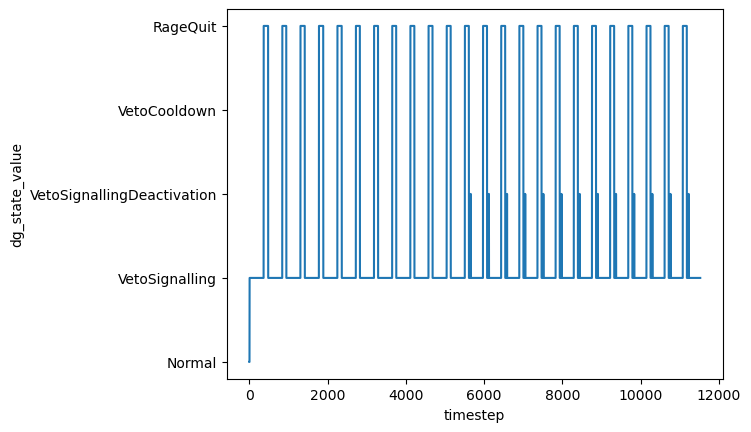

In [22]:
sns.lineplot(data=timestep_data_df_full[timestep_data_df_full["run_id"] == 3], x="timestep", y="dg_state_value")
plt.yticks([1, 2, 3, 4, 5])
from matplotlib.ticker import FuncFormatter

plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{State(x).name}"))

<Axes: xlabel='timestep', ylabel='dg_state_value'>

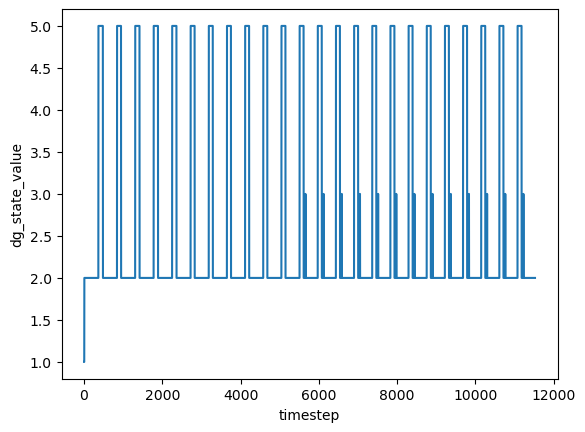

In [23]:
sns.lineplot(data=timestep_data_df_full[timestep_data_df_full["run_id"] == 3], x="timestep", y="dg_state_value")